# PROYECTO PREPARACIÓN Y LIMPIEZA DE DATOS

## Health Insurance Cross Sell Prediction

El proyecto a desarrollar consta de datos de clientes que una compañia de seguros ha cedido para realizar un modelo predictivo y decidir si los clientes de la anualidad anterior sería elegibles para ofrecerles una póliza para su coche.

El valor que el proyecto aporta a la compañia está relacionado con optimizar los costes de las campañas de marketing y así reducir los costes y eitar publicidad innecesaria a clientes que haya poca o nula posibilidad que contarten dicho seguro para su coche.

El proyecto consiste en dos datasets, uno para realizar el entrenamiento del modelo y otro para realizar el test y comprobar su rendimiento. 

El dataset ha sido obtenido de Kaggle: https://www.kaggle.com/datasets/anmolkumar/health-insurance-cross-sell-prediction?resource=download&select=train.csv

---------------------------------------------------------------------------------------------------------------------------------------------------

# Prerrequisitos

### Importar librerías

In [86]:
# ====================================================
# Básicas y Manipulación de Datos
# ====================================================
import random
import warnings

import numpy as np
import pandas as pd
import pyarrow as pa

# ====================================================
# Visualización de Datos
# ====================================================
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as ex
from matplotlib.colors import ListedColormap

# ====================================================
# Utilidades para Kaggle
# ====================================================
import kagglehub

# ====================================================
# Generación de Datos Sintéticos
# ====================================================
from sklearn.datasets import make_regression, make_blobs

# ====================================================
# Preprocesamiento de Datos
# ====================================================
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

# ====================================================
# Manejo de Desbalanceo de Clases
# ====================================================
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
# ====================================================
# Selección de Características
# ====================================================
from sklearn.feature_selection import RFECV, SelectKBest, f_regression

# ====================================================
# Modelado y Evaluación
# ====================================================
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    RepeatedKFold,
    GridSearchCV
)
from sklearn.pipeline import Pipeline

# Modelos de Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

# Métricas y Evaluación de Modelos
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)
from sklearn.inspection import permutation_importance

In [2]:
# Download latest version
path = kagglehub.dataset_download("anmolkumar/health-insurance-cross-sell-prediction")

print("Path to dataset files:", path)

path_to_train = path + "/train.csv" 
path_to_test = path + "/test.csv"

Path to dataset files: /Users/ale/.cache/kagglehub/datasets/anmolkumar/health-insurance-cross-sell-prediction/versions/1


Con este código descargamos el dataset directamente de Kaggle si no se tiene descargado en local. Este método ayuda mucho a una posterior ejecución en otro entorno 

### Cargamos el dataset 

In [3]:
df = pd.read_csv(path_to_train)#Cargamos el df

In [4]:
df.head()

id  Gender  Age  Driving_License  Region_Code  Previously_Insured  \
0   1    Male   44                1         28.0                   0   
1   2    Male   76                1          3.0                   0   
2   3    Male   47                1         28.0                   0   
3   4    Male   21                1         11.0                   1   
4   5  Female   29                1         41.0                   1   

  Vehicle_Age Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  Vintage  \
0   > 2 Years            Yes         40454.0                  26.0      217   
1    1-2 Year             No         33536.0                  26.0      183   
2   > 2 Years            Yes         38294.0                  26.0       27   
3    < 1 Year             No         28619.0                 152.0      203   
4    < 1 Year             No         27496.0                 152.0       39   

   Response  
0         1  
1         0  
2         1  
3         0  
4         0

### Columnas del dataset 

Ahora, para predecir si el cliente estará interesado en un seguro de vehículo, se dispone de información sobre datos demográficos (sexo, edad, tipo de código regional), vehículos (antigüedad del vehículo, daños), póliza (prima, canal de contratación), etc.

1. id: Identificador unico ID de cada cliente.

2. Gender: Género del asegurado.

3. Age: Edad del asegurado.

4. Driving_License: 0: El asegurado no tiene permiso de conducción, 1: El asegurado tiene permiso de conducción.

5. Region_Code: Código único para la región a la que pertenece el asegurado.

6. Previously_Insured: 0: El cliente no tiene una póliza de seguro para el vehículo con la compañia, 1: El cliente ya tiene contratada una póliza de seguro de vehículo con la compañia.

7. Vehicle_Age: Edad del vehículo.

8. Vehicle_Damage: 0: El vehículo del asegurado no ha tenido daños en el pasado, 1: El vehículo del asegurado ha tenido daños en el pasado.

9. Annual_Premium: La prima de cada cliente

10. Policy_Sales_Channel: Código anónimo para el canal de contacto con el cliente, es decir, diferentes agentes, por correo, por teléfono, en persona, etc.

11. Vintage: Numero de días que el cliente ha estado asociado a la compañia

12. Response: 0: El cliente no está interesado en una póliza para el vehículo, 1: El cliente está interesado en una póliza para el vehículo.

---------------------------------------------------------------------------------------------------------------------------------------------------

# 1 Entendiendo el dataset

### 1.1 - Check the head, shape, data-types of the features

Comprobamos los datatypes de cada columna del dataframe

In [5]:
for column in df.columns:
    print(f"{column} : {df[column].dtype}")

id : int64
Gender : object
Age : int64
Driving_License : int64
Region_Code : float64
Previously_Insured : int64
Vehicle_Age : object
Vehicle_Damage : object
Annual_Premium : float64
Policy_Sales_Channel : float64
Vintage : int64
Response : int64


In [6]:
print(df.shape)

(381109, 12)


### 1.2 Check the statistical values of features


In [7]:
df.describe()

id            Age  Driving_License    Region_Code  \
count  381109.000000  381109.000000    381109.000000  381109.000000   
mean   190555.000000      38.822584         0.997869      26.388807   
std    110016.836208      15.511611         0.046110      13.229888   
min         1.000000      20.000000         0.000000       0.000000   
25%     95278.000000      25.000000         1.000000      15.000000   
50%    190555.000000      36.000000         1.000000      28.000000   
75%    285832.000000      49.000000         1.000000      35.000000   
max    381109.000000      85.000000         1.000000      52.000000   

       Previously_Insured  Annual_Premium  Policy_Sales_Channel  \
count       381109.000000   381109.000000         381109.000000   
mean             0.458210    30564.389581            112.034295   
std              0.498251    17213.155057             54.203995   
min              0.000000     2630.000000              1.000000   
25%              0.000000    24405.000000             29.000000   
50%              0.000000    31669.000000            133.000000   
75%              1.000000    39400.000000            152.000000   
max              1.000000   540165.000000            163.000000   

             Vintage       Response  
count  381109.000000  381109.000000  
mean      154.347397       0.122563  
std        83.671304       0.327936  
min        10.000000       0.000000  
25%        82.000000       0.000000  
50%       154.000000       0.000000  
75%       227.000000       0.000000  
max       299.000000       1.000000

### 1.3 Identifique las columnas que contienen un valor único

Elimine las columnas que contengan un solo valor

In [8]:
columnas_pocos_valores = {}
columnas_muchos_valores = {}

for column in df.columns:
    n_unique = df[column].nunique()  # En Pandas se usa .nunique()
    
    if n_unique < 5:
        columnas_pocos_valores[column] = n_unique
    else:
        columnas_muchos_valores[column] = n_unique

    print(f"{column} : {n_unique}")

# Opcional: Mostrar los resultados de forma clara
print("\nColumnas con pocos valores únicos 'Variables Categóricas'")
print(columnas_pocos_valores)

print("\nColumnas con muchos valores únicos 'Variables Numéricas'")
print(columnas_muchos_valores)


id : 381109
Gender : 2
Age : 66
Driving_License : 2
Region_Code : 53
Previously_Insured : 2
Vehicle_Age : 3
Vehicle_Damage : 2
Annual_Premium : 48838
Policy_Sales_Channel : 155
Vintage : 290
Response : 2

Columnas con pocos valores únicos 'Variables Categóricas'
{'Gender': 2, 'Driving_License': 2, 'Previously_Insured': 2, 'Vehicle_Age': 3, 'Vehicle_Damage': 2, 'Response': 2}

Columnas con muchos valores únicos 'Variables Numéricas'
{'id': 381109, 'Age': 66, 'Region_Code': 53, 'Annual_Premium': 48838, 'Policy_Sales_Channel': 155, 'Vintage': 290}


Como se pede observar no existe ninguna columna con un único valor, las columnas con menos categorías son 2 por lo que no es necesario realizar ninguna operación por ahora.

Podemos observar tambien que las variables con pocos valores son las categoricas mientras que las que tienen muchos valores son las continuas. Vamos a separarlas para estudar la varianza de las variables contínuas.



In [9]:
# Seleccionar columnas categóricas (con pocos valores únicos)
variables_categoricas = df[list(columnas_pocos_valores.keys())]

# Seleccionar columnas numéricas (con muchos valores únicos)
variables_numericas = df[list(columnas_muchos_valores.keys())]


### 1.4 Considere las columnas que tienen muy pocos valores


Las columnas con valores únicos altos corresponden a columnas numéricas mientras que las que tienen valores inicos bajos se refieren a categóricas. Las variables categoricas se pueden transformar en variables booleanas para que el modelo lo interprete con mayor facilidad. No es necesario usar get_dummies puesto que solo tienen 2 categorías.

### 1.5 Quite las columnas que tengan una varianza baja


In [10]:
# Calcular varianza y desviación estándar de cada columna
variances = variables_numericas.var()
std_devs = variables_numericas.std()

# Combinar ambos resultados en un solo DataFrame
variances_df = pd.DataFrame({
    "varianza": variances,
    "desviacion_estandar": std_devs
}).reset_index()

# Renombrar las columnas
variances_df.columns = ["variable", "varianza", "desviacion_estandar"]

# Ordenar por la varianza
variances_df = variances_df.sort_values("varianza")

# Mostrar el DataFrame con varianza y desviación estándar
print(variances_df)

               variable      varianza  desviacion_estandar
2           Region_Code  1.750299e+02            13.229888
1                   Age  2.406101e+02            15.511611
4  Policy_Sales_Channel  2.938073e+03            54.203995
5               Vintage  7.000887e+03            83.671304
3        Annual_Premium  2.962927e+08         17213.155057
0                    id  1.210370e+10        110016.836208


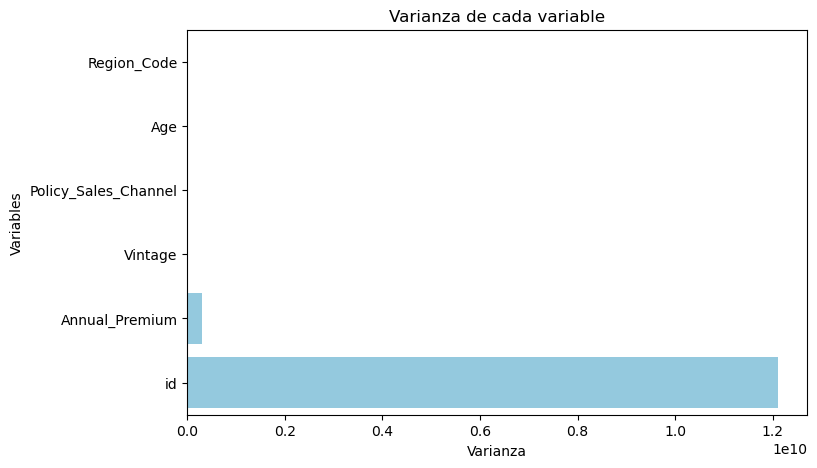

In [11]:
# Crear el gráfico de barras horizontales
plt.figure(figsize=(8, 5))
sns.barplot(x="varianza", y="variable", data=variances_df, orient="h", color='skyblue')
plt.title("Varianza de cada variable")
plt.xlabel("Varianza")
plt.ylabel("Variables")
plt.show()

Como podemos ver la escala de los valores es muy dispersa. Vamos a coregir esto y estandarizar las metricas para poder compararlas. Pare ello utilizareos el coeficiente de variación

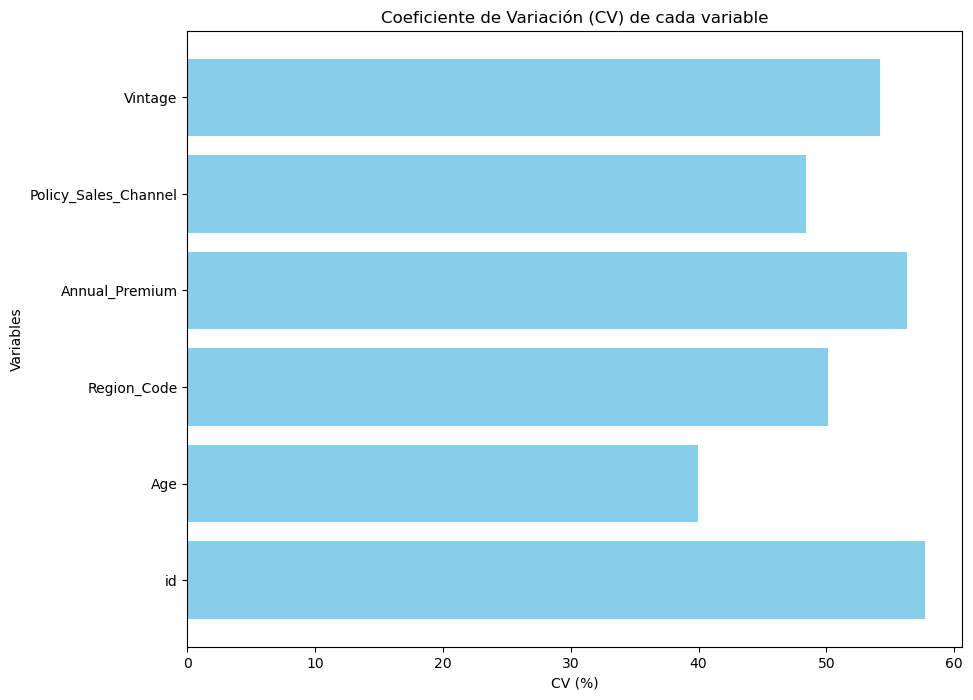

In [12]:
# Suponiendo que 'variables_numericas' es un DataFrame de Pandas
# Calcular el coeficiente de variación (CV) para cada columna
cv_df = variables_numericas.apply(lambda col: col.std() / col.mean() * 100)

# Transponer el DataFrame para la visualización
cv_df = cv_df.reset_index()
cv_df.columns = ['variable', 'cv']

# Crear el gráfico de barras horizontales con Matplotlib
plt.figure(figsize=(10, 8))
plt.barh(cv_df['variable'], cv_df['cv'], color='skyblue')
plt.title("Coeficiente de Variación (CV) de cada variable")
plt.xlabel("CV (%)")
plt.ylabel("Variables")
plt.show()

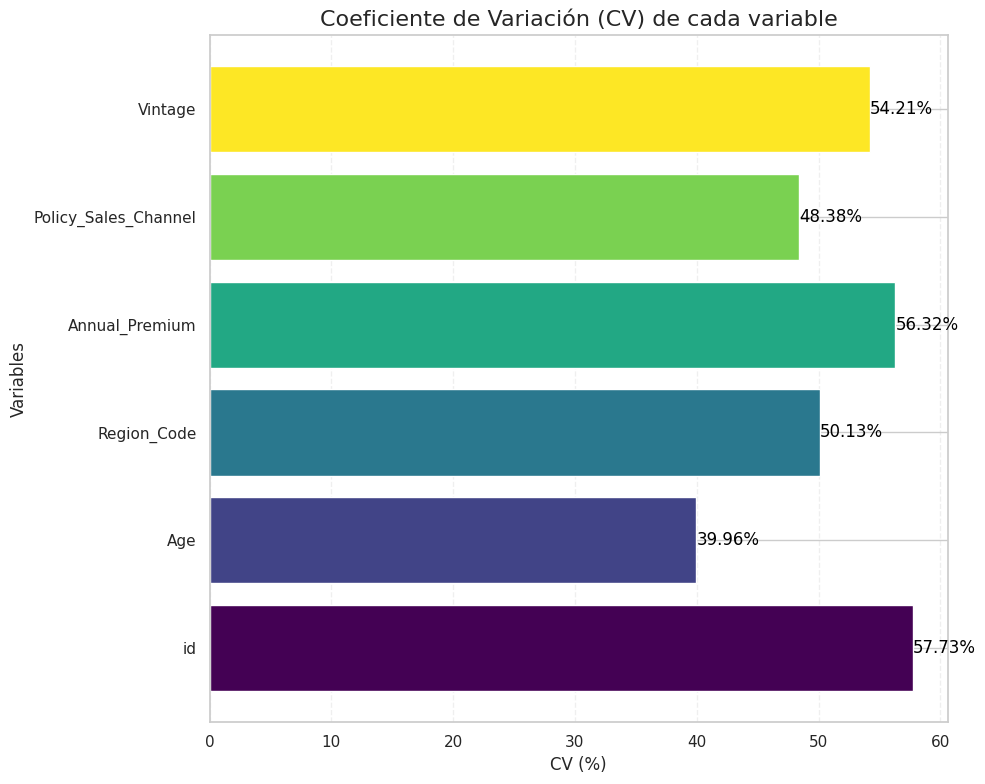

In [37]:
# Suponiendo que 'variables_numericas' es un DataFrame de Pandas
# Calcular el coeficiente de variación (CV) para cada columna
cv_df = variables_numericas.apply(lambda col: col.std() / col.mean() * 100)

# Transponer el DataFrame para la visualización
cv_df = cv_df.reset_index()
cv_df.columns = ['variable', 'cv']

# Extraer los datos de Pandas como listas
variables = cv_df['variable'].tolist()
cvs = cv_df['cv'].tolist()

# Crear el gráfico de barras horizontales con Matplotlib
plt.figure(figsize=(10, 8))
bars = plt.barh(variables, cvs, color=plt.cm.viridis(np.linspace(0, 1, len(variables))))

# Añadir etiquetas de valor en las barras
for bar in bars:
    plt.text(
        bar.get_width(), bar.get_y() + bar.get_height() / 2,  # Posición de la etiqueta
        f'{bar.get_width():.2f}%', # Texto de la etiqueta
        va='center', ha='left', # Alineación vertical y horizontal
        color='black'
    )

plt.title("Coeficiente de Variación (CV) de cada variable", fontsize=16)
plt.xlabel("CV (%)", fontsize=12)
plt.ylabel("Variables", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

Como se pude observar todas las variables numéricas tienen un coeficiente de variación en torno al 50 por ciento lo que no indica ni variabilidad muy alta ni muy baja

### 1.6 - Identifique las filas que contienen datos duplicados


In [13]:
df_duplicates = df[df.duplicated()]

print(df_duplicates)

Empty DataFrame
Columns: [id, Gender, Age, Driving_License, Region_Code, Previously_Insured, Vehicle_Age, Vehicle_Damage, Annual_Premium, Policy_Sales_Channel, Vintage, Response]
Index: []


Podemos observar que no existe ninguna fila duplicada, solo coinciden en que tienen el mismo valor para la variable 'Annual_Premium'

### 1.7 - check the missing values


In [14]:
for col in df.columns:
    print(f"La columna '{col}' contiene: {df[col].isnull().sum()} valores nulos")

La columna 'id' contiene: 0 valores nulos
La columna 'Gender' contiene: 0 valores nulos
La columna 'Age' contiene: 0 valores nulos
La columna 'Driving_License' contiene: 0 valores nulos
La columna 'Region_Code' contiene: 0 valores nulos
La columna 'Previously_Insured' contiene: 0 valores nulos
La columna 'Vehicle_Age' contiene: 0 valores nulos
La columna 'Vehicle_Damage' contiene: 0 valores nulos
La columna 'Annual_Premium' contiene: 0 valores nulos
La columna 'Policy_Sales_Channel' contiene: 0 valores nulos
La columna 'Vintage' contiene: 0 valores nulos
La columna 'Response' contiene: 0 valores nulos


Podemos observar que no existen valores nulos en el dataset

### 1.8 Detect strange values apart from the NaN Values

Vamos a checkear los outliers

In [15]:
# Función para detectar outliers usando el rango intercuartílico (IQR)
def detect_outliers(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return (df[col] < lower_bound) | (df[col] > upper_bound)  # Devuelve una serie booleana

# Aplicar la función de detección de outliers a cada columna numérica
outliers_df = pd.DataFrame({col: detect_outliers(df, col) for col in variables_numericas})

# Contar el número de outliers por columna
outliers_count = outliers_df.sum()

# Contar el total de outliers en el dataset
total_outliers = outliers_df.any(axis=1).sum()

# Calcular el porcentaje de outliers respecto al total de filas
total_rows = len(df)
outlier_percentage = (total_outliers / total_rows) * 100

# Filtrar las filas que tienen al menos un outlier
df_outliers_filtered = df[outliers_df.any(axis=1)]

# Mostrar resultados
print("Número de outliers por columna:")
print(outliers_count)
print(f"\nTotal de filas con al menos un outlier: {total_outliers} de {total_rows} ({outlier_percentage:.2f}%)")
print("\nDataFrame con filas que contienen outliers:")
df_outliers_filtered

Número de outliers por columna:
id                          0
Age                         0
Region_Code                 0
Annual_Premium          10320
Policy_Sales_Channel        0
Vintage                     0
dtype: int64

Total de filas con al menos un outlier: 10320 de 381109 (2.71%)

DataFrame con filas que contienen outliers:


id  Gender  Age  Driving_License  Region_Code  Previously_Insured  \
25          26  Female   21                1         28.0                   1   
37          38  Female   25                1         28.0                   1   
67          68    Male   60                1         28.0                   0   
139        140    Male   21                1         29.0                   1   
149        150  Female   22                1         11.0                   1   
...        ...     ...  ...              ...          ...                 ...   
380959  380960    Male   25                1          8.0                   1   
380998  380999  Female   33                1          8.0                   0   
381035  381036  Female   22                1         11.0                   1   
381047  381048  Female   52                1          8.0                   1   
381079  381080    Male   33                1         28.0                   0   

       Vehicle_Age Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  \
25        < 1 Year             No         61964.0                 152.0   
37        < 1 Year             No         76251.0                 152.0   
67        1-2 Year            Yes         66338.0                 124.0   
139       < 1 Year             No         62164.0                 152.0   
149       < 1 Year             No         76651.0                 152.0   
...            ...            ...             ...                   ...   
380959    < 1 Year             No         61909.0                 152.0   
380998    1-2 Year            Yes        101664.0                 124.0   
381035    < 1 Year             No         62889.0                 152.0   
381047    1-2 Year             No         71915.0                   7.0   
381079    < 1 Year            Yes         69845.0                  26.0   

        Vintage  Response  
25           72         0  
37          107         0  
67           73         0  
139         116         0  
149         258         0  
...         ...       ...  
380959      161         0  
380998       21         0  
381035      295         0  
381047      233         0  
381079      115         0  

[10320 rows x 12 columns]

Comprobamos que solo aparecen "Outliers" en a variable Annual_premium", por lo que vamos a indagar mas en esta variable para ver como se comporta y si realmente son outliers

Vamos a graficar los violincharts de las columnas numéricas, es decir las no categóricas

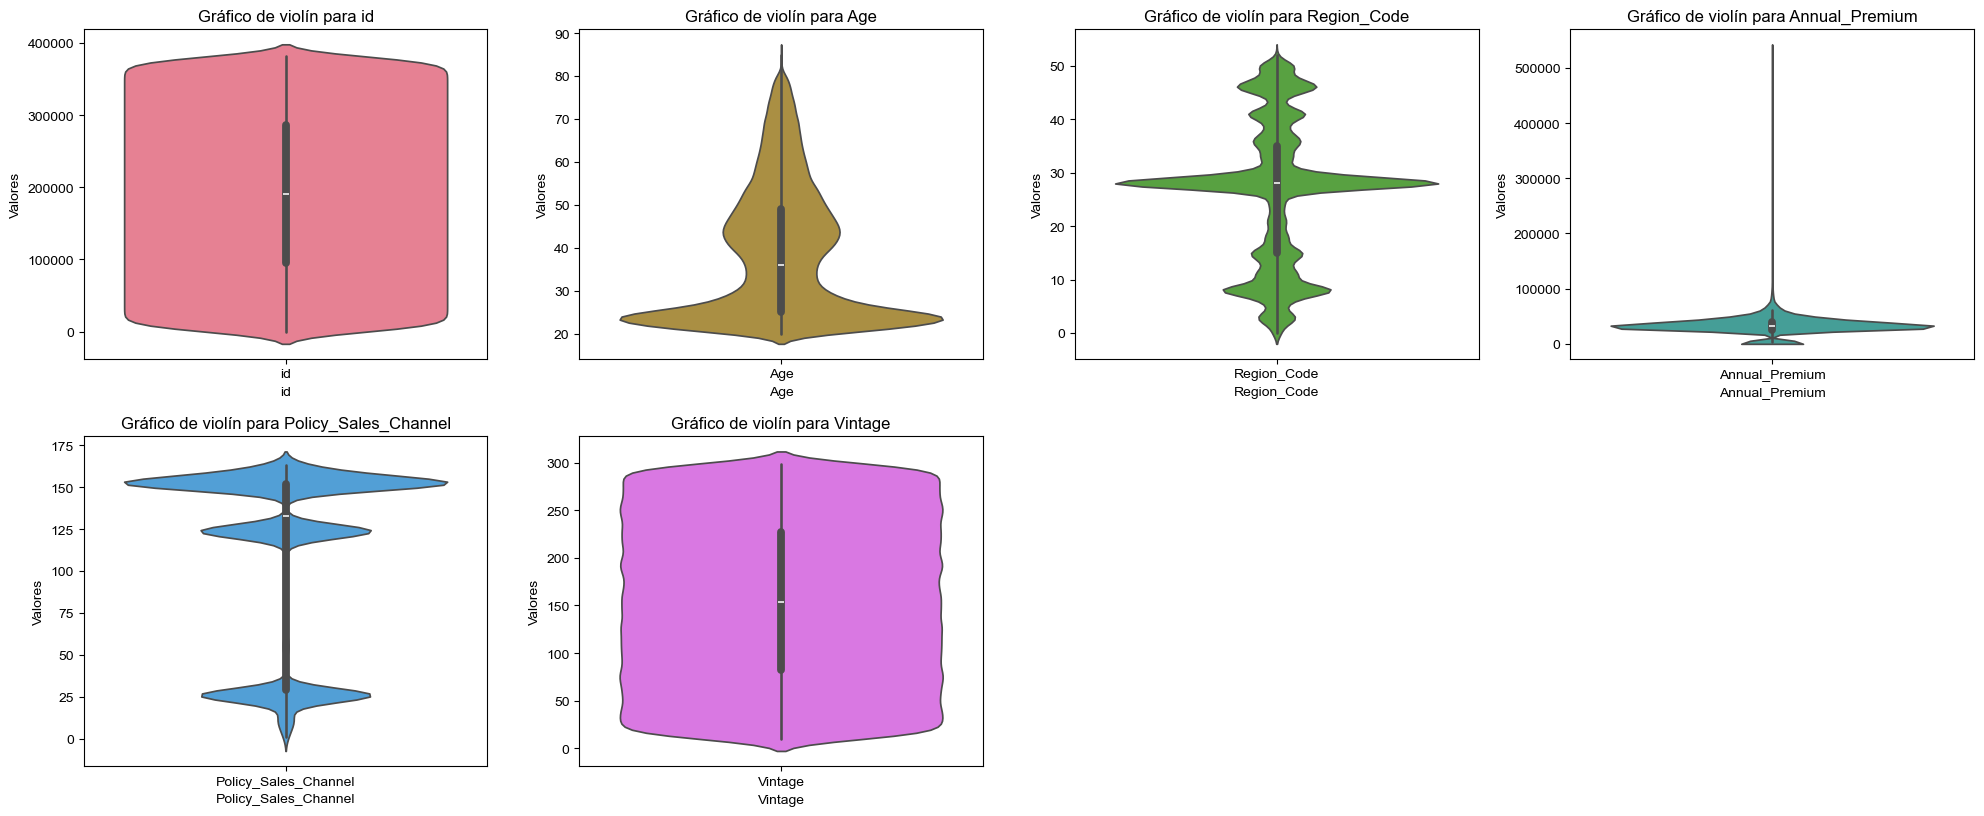

In [16]:
# Crear una cuadrícula de gráficos de violín con 4 gráficos por línea
num_cols = len(df.columns)
num_plots_per_row = 4
num_rows = (num_cols + num_plots_per_row - 1) // num_plots_per_row

fig, axes = plt.subplots(num_rows, num_plots_per_row, figsize=(20, 4 * num_rows))
sns.set(style="whitegrid")
palette = sns.color_palette("husl", len(columnas_muchos_valores))


for i, column in enumerate(columnas_muchos_valores.keys()):
    row = i // num_plots_per_row
    col = i % num_plots_per_row
    sns.violinplot(ax=axes[row, col], data=df[[column]], color=palette[i])
    axes[row, col].set_title(f'Gráfico de violín para {column}')
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel('Valores')

# Eliminar ejes vacíos
for j in range(i + 1, num_rows * num_plots_per_row):
    fig.delaxes(axes[j // num_plots_per_row, j % num_plots_per_row])

plt.tight_layout()
plt.show()

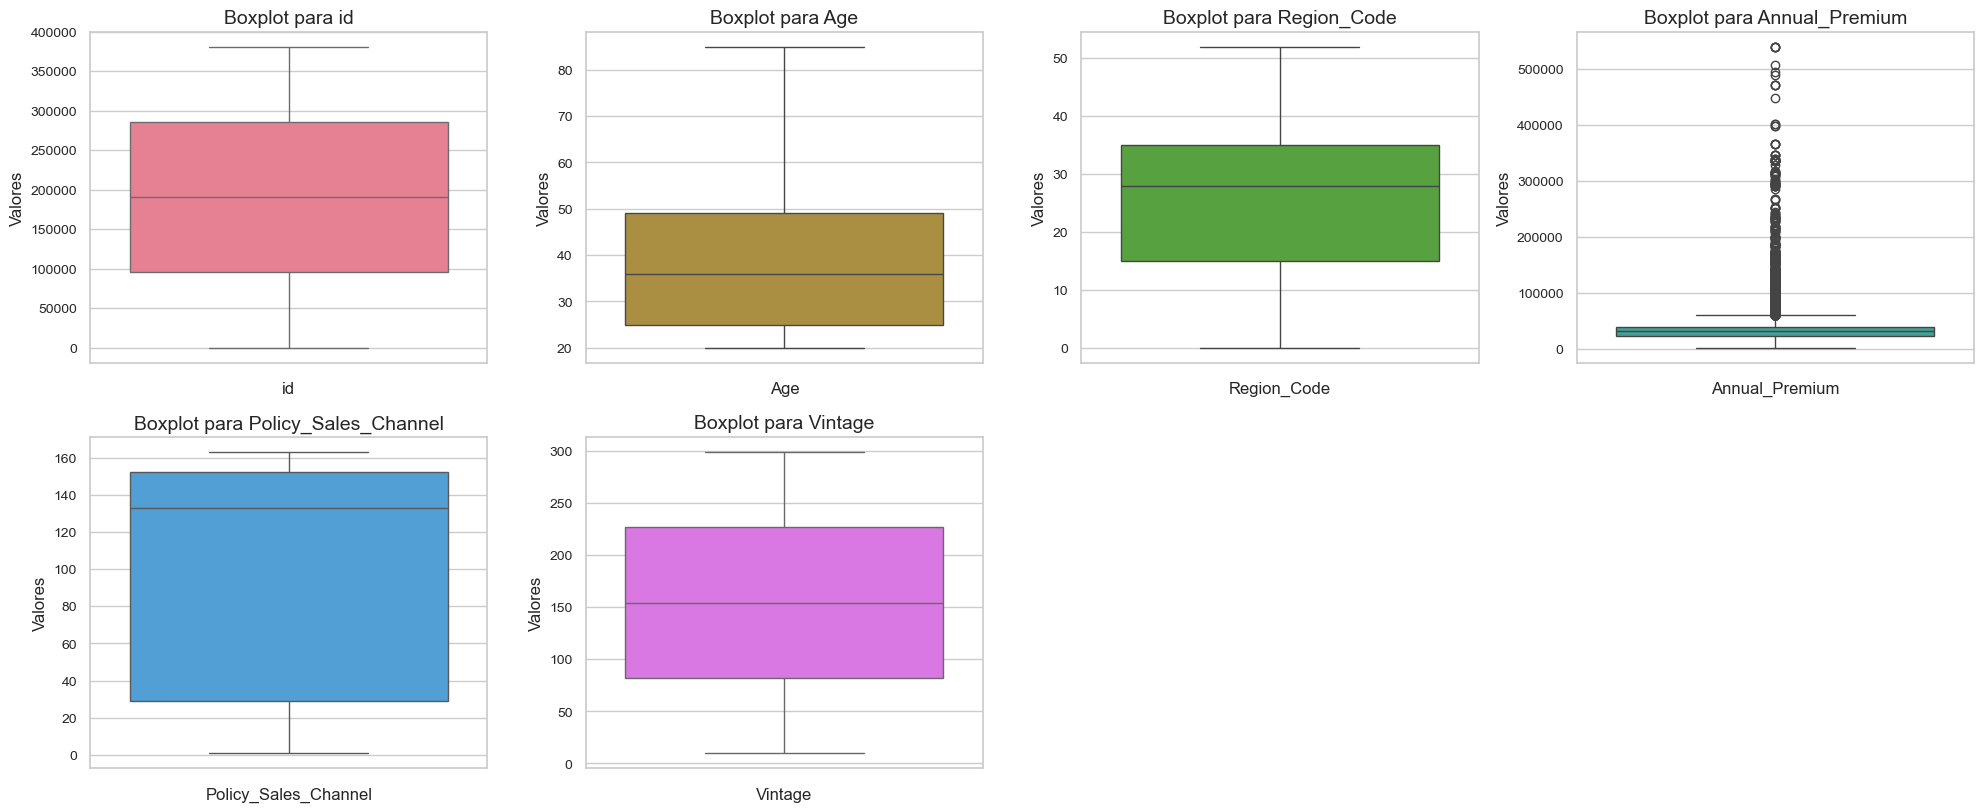

In [17]:
num_cols = len(df.columns)
num_plots_per_row = 4
num_rows = (num_cols + num_plots_per_row - 1) // num_plots_per_row

fig, axes = plt.subplots(num_rows, num_plots_per_row, figsize=(20, 4 * num_rows))

sns.set(style="whitegrid")

palette = sns.color_palette("husl", len(columnas_muchos_valores))
                            
for i, column in enumerate(columnas_muchos_valores.keys()):
    row = i // num_plots_per_row
    col = i % num_plots_per_row
    sns.boxplot(ax=axes[row, col], data=df[column],color=palette[i])
    axes[row, col].set_title(f'Boxplot para {column}', fontsize=14)
    axes[row, col].set_xlabel(column, fontsize=12)
    axes[row, col].set_ylabel('Valores', fontsize=12)
    axes[row, col].tick_params(axis='both', which='major', labelsize=10)

# Eliminar ejes vacíos
for j in range(i + 1, num_rows * num_plots_per_row):
    fig.delaxes(axes[j // num_plots_per_row, j % num_plots_per_row])

plt.tight_layout()
plt.show()

# Posible problema !!

Si analizamos la columna Annual_Premium que analiza la poliza de cada cliente podemos ver que la mayoria de los datos se acumulan en una distribucion normal en valores por debajo de 100k. Sin embargo vemos tambien que hay una larga cola hacia la derecha lo que puede indicar un subproblema para rentas mas altas. vamos a segmentar el dataset y analizar los outliers a ver como se distribuyen, su numero y si merece ahcer un modelado aparte para estos datos.

La columna id la podemos obviar puesto que es una columna de identificadores únicos

Vamos a establecer una separación en el dataset para clientes que pagan una prima superior e inferior, separándolos en dos categorias

In [18]:
# Calcular los cuartiles y el rango intercuartílico (IQR)
q1 = df['Annual_Premium'].quantile(0.15)
q3 = df['Annual_Premium'].quantile(0.85)
IQR = q3 - q1
upper_bound = q3 + 1.5 * IQR
lower_bound = q1 - 1.5 * IQR

In [19]:
# Filtrar los valores dentro del rango (menor o igual que upper_bound)
df_filtrado = df[df['Annual_Premium'] <= upper_bound]

# Filtrar los valores fuera del rango (mayor o igual que upper_bound)
df_filtrado_premium = df[df['Annual_Premium'] >= upper_bound]

Volvemos a comprobar distribuciones de df_filtrado, con los clientes con una prima inferior a 107k y clientes premium con primas superiores a esto.

#### Dataframe con clientes premium Violinchart y Boxplot

In [20]:
df_filtrado_premium.shape

(546, 12)

In [21]:
min_annual_premium = df_filtrado_premium['Annual_Premium'].min()
print(min_annual_premium)

107446.0


Vemos que el df ha establecido que el corte de la distribucón por prima se establezca en 107k.

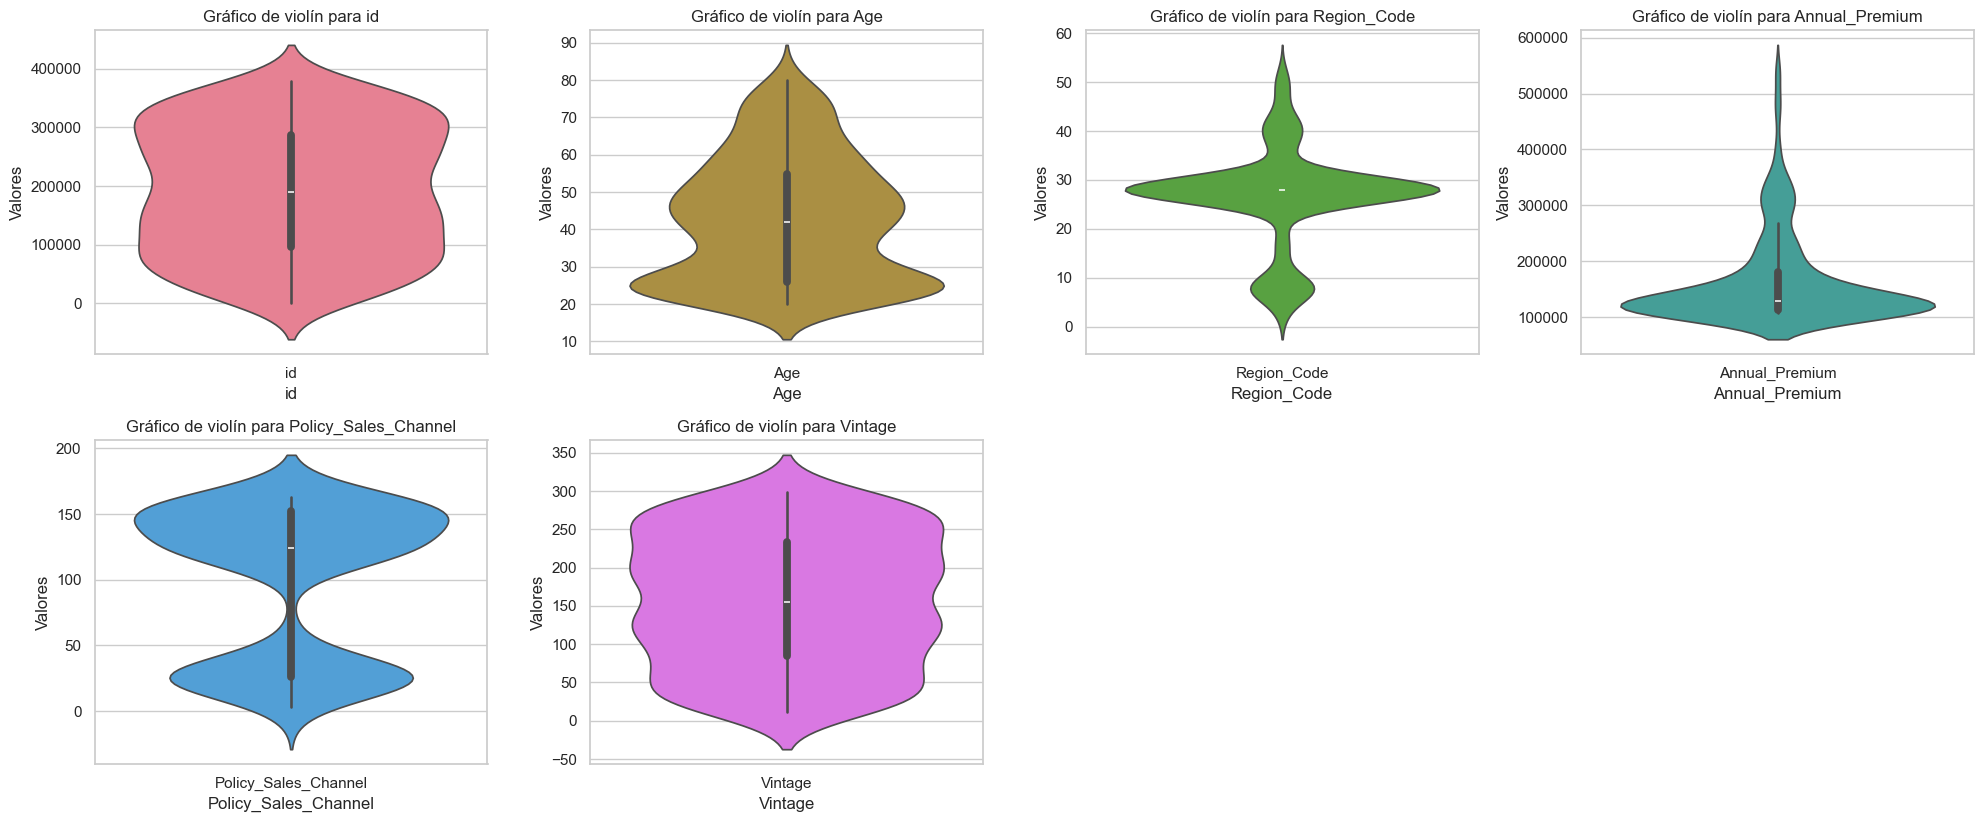

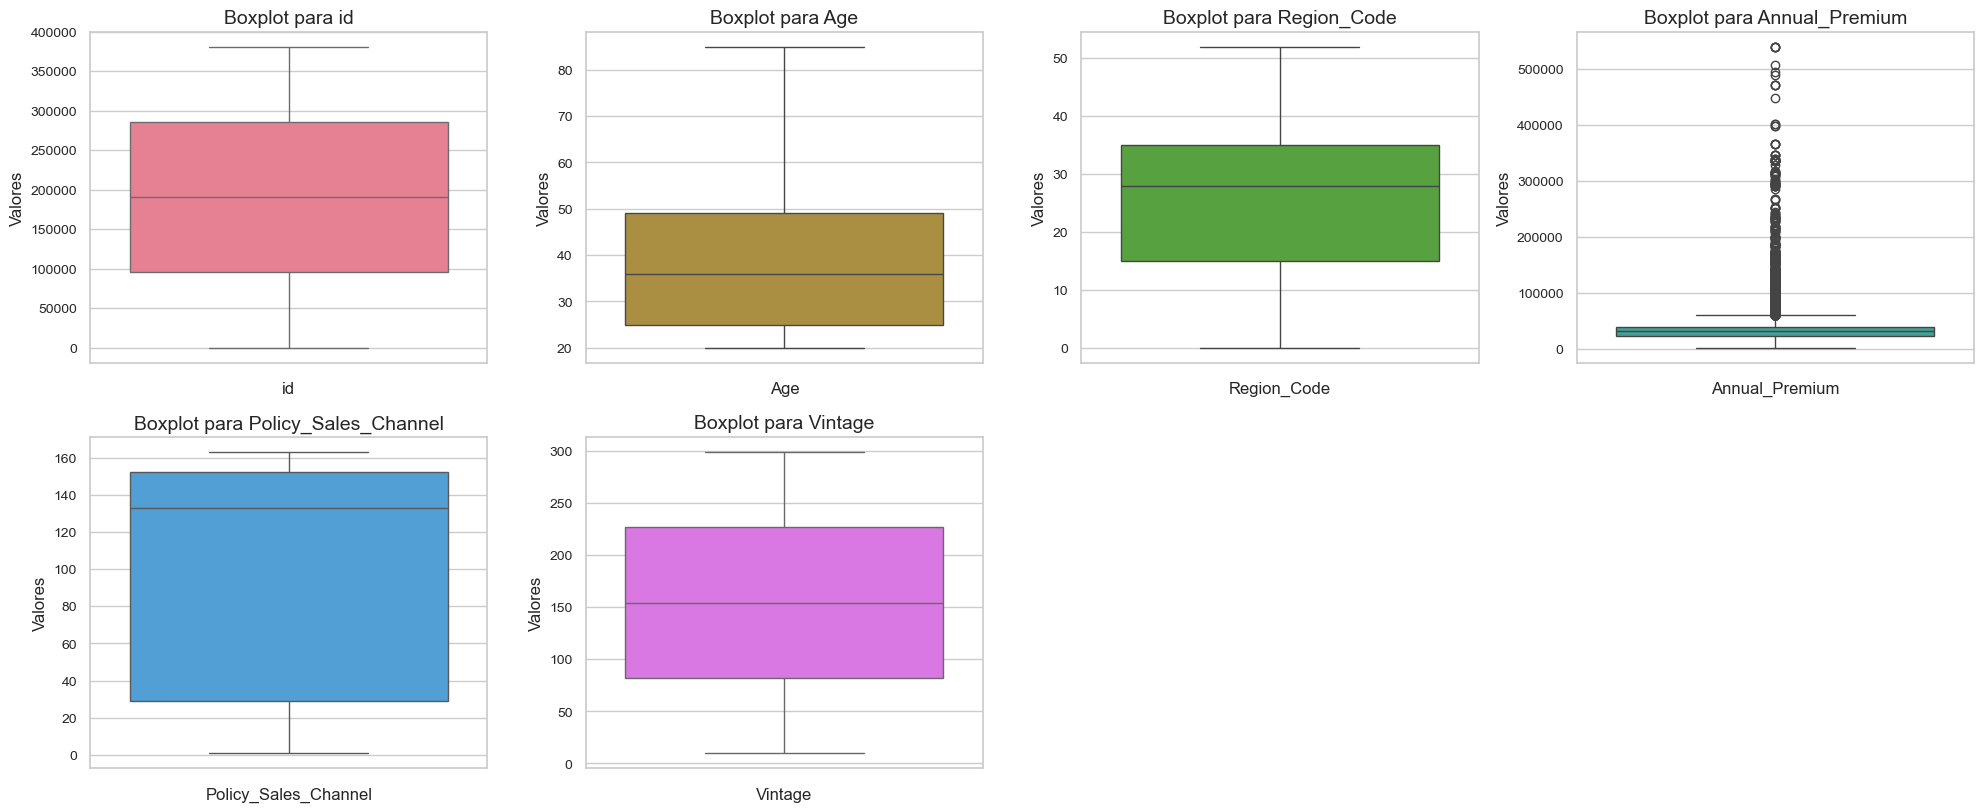

In [22]:
# Crear una cuadrícula de gráficos de violín con 4 gráficos por línea
num_cols = len(df_filtrado_premium.columns)
num_plots_per_row = 4
num_rows = (num_cols + num_plots_per_row - 1) // num_plots_per_row

fig, axes = plt.subplots(num_rows, num_plots_per_row, figsize=(20, 4 * num_rows))
sns.set(style="whitegrid")
palette = sns.color_palette("husl", len(columnas_muchos_valores))


for i, column in enumerate(columnas_muchos_valores.keys()):
    row = i // num_plots_per_row
    col = i % num_plots_per_row
    sns.violinplot(ax=axes[row, col], data=df_filtrado_premium[[column]], color=palette[i])
    axes[row, col].set_title(f'Gráfico de violín para {column}')
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel('Valores')

# Eliminar ejes vacíos
for j in range(i + 1, num_rows * num_plots_per_row):
    fig.delaxes(axes[j // num_plots_per_row, j % num_plots_per_row])

plt.tight_layout()
plt.show()

# Boxplot

num_cols = len(df_filtrado_premium.columns)
num_plots_per_row = 4
num_rows = (num_cols + num_plots_per_row - 1) // num_plots_per_row

fig, axes = plt.subplots(num_rows, num_plots_per_row, figsize=(20, 4 * num_rows))

sns.set(style="whitegrid")

palette = sns.color_palette("husl", len(columnas_muchos_valores))
                            
for i, column in enumerate(columnas_muchos_valores.keys()):
    row = i // num_plots_per_row
    col = i % num_plots_per_row
    sns.boxplot(ax=axes[row, col], data=df[column],color=palette[i])
    axes[row, col].set_title(f'Boxplot para {column}', fontsize=14)
    axes[row, col].set_xlabel(column, fontsize=12)
    axes[row, col].set_ylabel('Valores', fontsize=12)
    axes[row, col].tick_params(axis='both', which='major', labelsize=10)

# Eliminar ejes vacíos
for j in range(i + 1, num_rows * num_plots_per_row):
    fig.delaxes(axes[j // num_plots_per_row, j % num_plots_per_row])

plt.tight_layout()
plt.show()

#### Dataframe con clientes estandar Violinchart y Boxplot

In [23]:
df_filtrado.shape

(380563, 12)

In [24]:
max_annual_premium = df_filtrado['Annual_Premium'].max()
print(max_annual_premium)

107292.0


Vemos que para este segento de clientes, el mayor valor que toma la prima es de 107k.

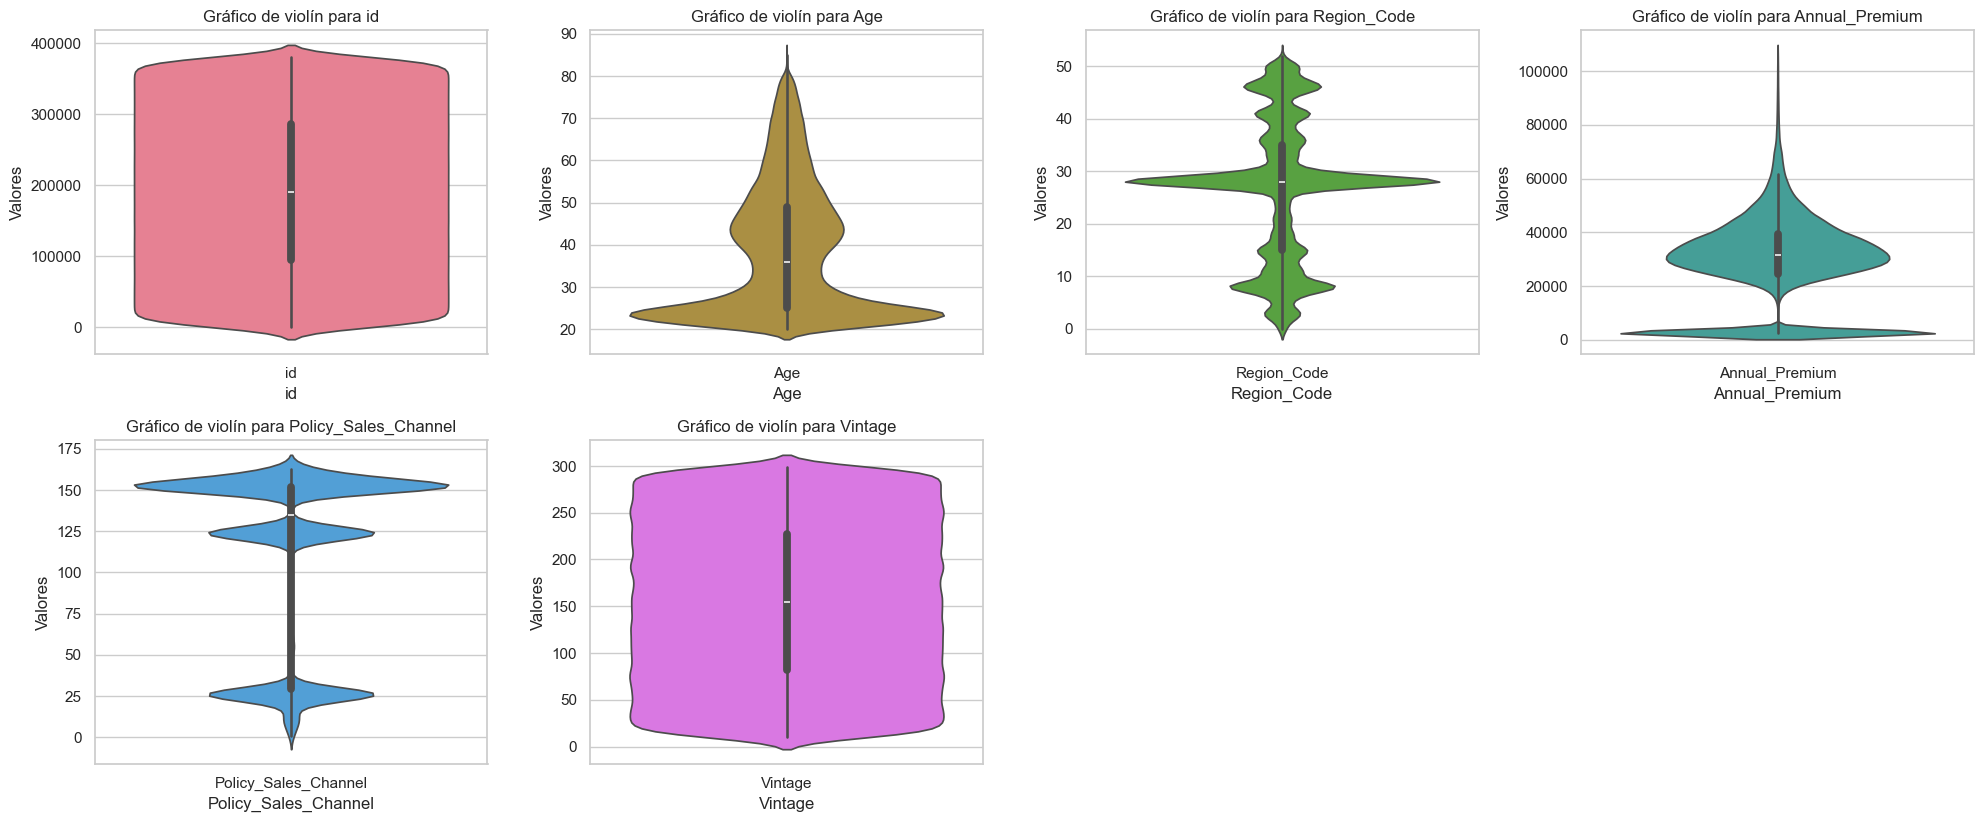

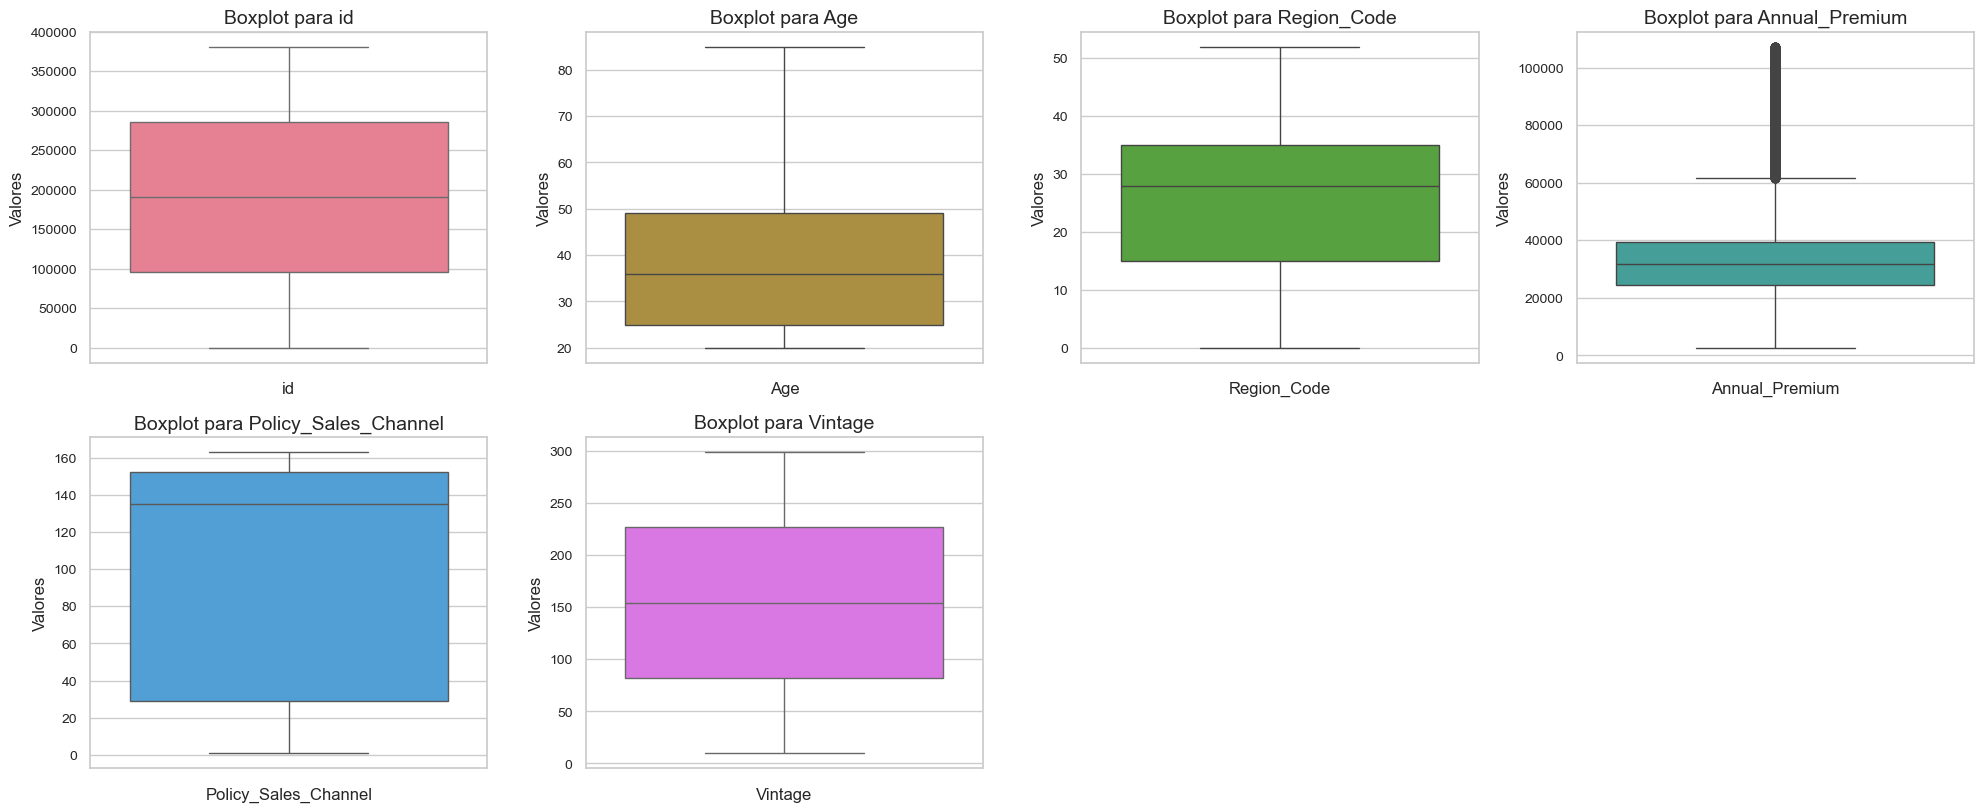

In [25]:
# Crear una cuadrícula de gráficos de violín con 4 gráficos por línea
num_cols = len(df_filtrado.columns)
num_plots_per_row = 4
num_rows = (num_cols + num_plots_per_row - 1) // num_plots_per_row

fig, axes = plt.subplots(num_rows, num_plots_per_row, figsize=(20, 4 * num_rows))
sns.set(style="whitegrid")
palette = sns.color_palette("husl", len(columnas_muchos_valores))


for i, column in enumerate(columnas_muchos_valores.keys()):
    row = i // num_plots_per_row
    col = i % num_plots_per_row
    sns.violinplot(ax=axes[row, col], data=df_filtrado[[column]], color=palette[i])
    axes[row, col].set_title(f'Gráfico de violín para {column}')
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel('Valores')

# Eliminar ejes vacíos
for j in range(i + 1, num_rows * num_plots_per_row):
    fig.delaxes(axes[j // num_plots_per_row, j % num_plots_per_row])

plt.tight_layout()
plt.show()

num_cols = len(df_filtrado.columns)
num_plots_per_row = 4
num_rows = (num_cols + num_plots_per_row - 1) // num_plots_per_row

fig, axes = plt.subplots(num_rows, num_plots_per_row, figsize=(20, 4 * num_rows))

sns.set(style="whitegrid")

palette = sns.color_palette("husl", len(columnas_muchos_valores))
                            
for i, column in enumerate(columnas_muchos_valores.keys()):
    row = i // num_plots_per_row
    col = i % num_plots_per_row
    sns.boxplot(ax=axes[row, col], data=df_filtrado[column],color=palette[i])
    axes[row, col].set_title(f'Boxplot para {column}', fontsize=14)
    axes[row, col].set_xlabel(column, fontsize=12)
    axes[row, col].set_ylabel('Valores', fontsize=12)
    axes[row, col].tick_params(axis='both', which='major', labelsize=10)

# Eliminar ejes vacíos
for j in range(i + 1, num_rows * num_plots_per_row):
    fig.delaxes(axes[j // num_plots_per_row, j % num_plots_per_row])

plt.tight_layout()
plt.show()

Como podemos ver, la cola de Anual_Premium ha disminuido considerablemente.

Usaremos df_original como el que no tiene ningun cambio y df_fe al cual le copiaremos el segmento de clientes retail al que le haremos feature engineering.

In [28]:
df_original = df
df_fe = df_filtrado.copy()

### 1.9 - Drop the attributes that provide no useful information


In [36]:
df_fe.head()

id  Gender  Age  Driving_License  Region_Code  Previously_Insured  \
0   1    Male   44                1         28.0                   0   
1   2    Male   76                1          3.0                   0   
2   3    Male   47                1         28.0                   0   
3   4    Male   21                1         11.0                   1   
4   5  Female   29                1         41.0                   1   

  Vehicle_Age Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  Vintage  \
0   > 2 Years            Yes         40454.0                  26.0      217   
1    1-2 Year             No         33536.0                  26.0      183   
2   > 2 Years            Yes         38294.0                  26.0       27   
3    < 1 Year             No         28619.0                 152.0      203   
4    < 1 Year             No         27496.0                 152.0       39   

   Response  
0         1  
1         0  
2         1  
3         0  
4         0

Vamos a eliminar la variable id ya que como hemos visto, solo es un identificador y no aporta nada.

In [ ]:
df_fe = df_fe.drop(columns=['id'])

Vamos a estudiar correlación entre las variables con la matriz de correlación

In [39]:
df_corr = df_fe.copy()

# Convertir las columnas binarias a 0 y 1
df_corr["Driving_License"] = df_corr["Driving_License"].astype(int)
df_corr["Previously_Insured"] = df_corr["Previously_Insured"].astype(int)
df_corr["Response"] = df_corr["Response"].astype(int)
df_corr["Gender"] = df_corr["Gender"].map({"Male": 1, "Female": 0})  # Asignar 1 a "Male" y 0 a "Female"
df_corr["Vehicle_Damage"] = df_corr["Vehicle_Damage"].map({"Yes": 1, "No": 0})  # Asignar 1 a "Yes" y 0 a "No"

# Convertir "Vehicle_Age" a valores ordinales
df_corr["Vehicle_Age"] = df_corr["Vehicle_Age"].map({
    "< 1 Year": 0,  # Más nuevo
    "1-2 Year": 1,
    "> 2 Years": 2   # Más viejo
})

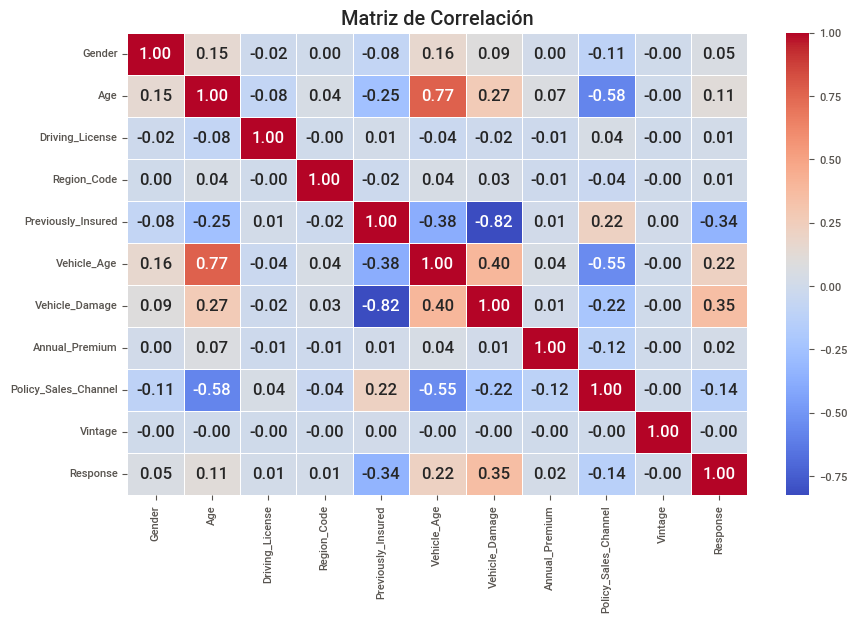

In [40]:
# Calcular la matriz de correlación
corr_matrix = df_corr.corr()

# Visualizar con un mapa de calor
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación")
plt.show()

# Selección de variables

In [41]:

# Fijar la semilla para reproducibilidad
np.random.seed(10)
random.seed(10)

# Necesitamos transformar las variables categóricas para que el modelo pueda entenderlas
df_RFECV = df_fe.copy()

# Convertir variables categóricas
df_RFECV["Gender"] = df_RFECV["Gender"].map({"Male": 0, "Female": 1})  # Label Encoding para Gender
df_RFECV["Vehicle_Damage"] = df_RFECV["Vehicle_Damage"].map({"No": 0, "Yes": 1})  # Label Encoding para Vehicle_Damage

# Label Encoding manual para Vehicle_Age (porque tiene orden)
df_RFECV["Vehicle_Age"] = df_RFECV["Vehicle_Age"].map({"< 1 Year": 0, "1-2 Year": 1, "> 2 Years": 2})

# Definir X (variables independientes) e y (variable objetivo)
X = df_RFECV.drop(columns=['Response'])  # Reemplaza 'target' con el nombre de tu variable objetivo
y = df_fe['Response']  # Reemplaza 'target' con el nombre de tu variable objetivo

# Configurar RFECV para la selección automática de características
rfecv = RFECV(
    estimator=DecisionTreeRegressor(),
    step=1,
    cv=RepeatedKFold(n_splits=10, n_repeats=2, random_state=1),
    scoring='neg_mean_absolute_error',
    min_features_to_select=1
)

# Ajustar RFECV al conjunto de datos para seleccionar automáticamente el número óptimo de características
rfecv.fit(X, y)

# Resumen de las características seleccionadas
print("\nSelección de características con RFECV:")
for i, col in enumerate(X.columns):
    print(f'Columna: {col}, Seleccionada={rfecv.support_[i]}, Ranking: {rfecv.ranking_[i]}')

print(f"\nNúmero óptimo de características seleccionadas: {rfecv.n_features_}")


Selección de características con RFECV:
Columna: Gender, Seleccionada=True, Ranking: 1
Columna: Age, Seleccionada=True, Ranking: 1
Columna: Driving_License, Seleccionada=True, Ranking: 1
Columna: Region_Code, Seleccionada=True, Ranking: 1
Columna: Previously_Insured, Seleccionada=True, Ranking: 1
Columna: Vehicle_Age, Seleccionada=True, Ranking: 1
Columna: Vehicle_Damage, Seleccionada=True, Ranking: 1
Columna: Annual_Premium, Seleccionada=True, Ranking: 1
Columna: Policy_Sales_Channel, Seleccionada=True, Ranking: 1
Columna: Vintage, Seleccionada=True, Ranking: 1

Número óptimo de características seleccionadas: 10


Observando los resultados obtenidos, comprobamos que todas las variables predictoras aportan información.

Vamos a realizar otro análisis para comprobar cuales son las más relevantes:


Importancia de las características:
Característica: 1, Puntuación: 0.02606
Característica: 2, Puntuación: 0.13653
Característica: 3, Puntuación: 0.00051
Característica: 4, Puntuación: 0.10546
Característica: 5, Puntuación: 0.01227
Característica: 6, Puntuación: 0.01146
Característica: 7, Puntuación: 0.12556
Característica: 8, Puntuación: 0.26501
Característica: 9, Puntuación: 0.04651
Característica: 10, Puntuación: 0.27063


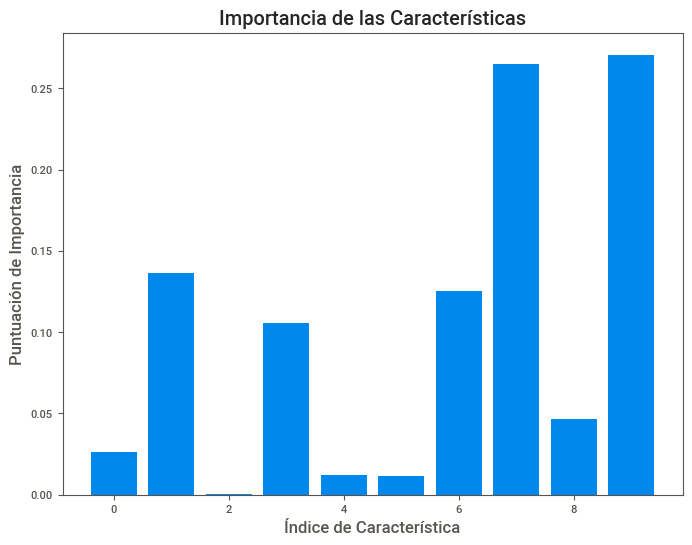

In [42]:

# Fijar la semilla para reproducibilidad
np.random.seed(10)
random.seed(10)

# Necesitamos transformar las variables categóricas para que el modelo pueda entenderlas
df_RFFE = df_fe.copy()

# Convertir variables categóricas
df_RFFE["Gender"] = df_RFFE["Gender"].map({"Male": 0, "Female": 1})  # Label Encoding para Gender
df_RFFE["Vehicle_Damage"] = df_RFFE["Vehicle_Damage"].map({"No": 0, "Yes": 1})  # Label Encoding para Vehicle_Damage

# Label Encoding manual para Vehicle_Age (porque tiene orden)
df_RFFE["Vehicle_Age"] = df_RFFE["Vehicle_Age"].map({"< 1 Year": 0, "1-2 Year": 1, "> 2 Years": 2})

# Definir X (variables independientes) e y (variable objetivo)
X = df_RFFE.drop(columns=['Response'])  # Reemplaza 'target' con el nombre de tu variable objetivo
y = df_RFFE['Response']  # Reemplaza 'target' con el nombre de tu variable objetivo

# Seleccionar el modelo
# Puedes elegir entre LinearRegression, Ridge, Lasso, ElasticNet o modelos basados en árboles
# model = LinearRegression()  # Modelos lineales
model = RandomForestRegressor(n_estimators=100, random_state=0)  # Basado en bosques aleatorios
#model = DecisionTreeRegressor(random_state=0)  # Modelo basado en árboles

# Ajustar el modelo
model.fit(X, y)

# Obtener la importancia de las características
if hasattr(model, 'coef_'):
    # Para modelos lineales
    importance = model.coef_
elif hasattr(model, 'feature_importances_'):
    # Para modelos basados en árboles
    importance = model.feature_importances_
else:
    raise ValueError("El modelo no tiene soporte para importancia de características.")

# Resumir la importancia de las características
print("\nImportancia de las características:")
for i, v in enumerate(importance):
    print(f'Característica: {i+1}, Puntuación: {v:.5f}')

# Visualizar la importancia de las características
plt.figure(figsize=(8, 6))
plt.bar([x for x in range(len(importance))], importance)
plt.title("Importancia de las Características")
plt.xlabel("Índice de Característica")
plt.ylabel("Puntuación de Importancia")
plt.show()

Ahora veremos a que predictor corresponden estas puntuaciones

In [43]:
# Obtener los nombres de las características
feature_names = X.columns

# Asociar las puntuaciones de importancia con los nombres de las características
importancia_caracteristicas = {feature_names[i]: importance[i] for i in range(len(importance))}

# Imprimir la importancia de cada característica con su nombre
print("\nImportancia de las características con sus nombres:")
for feature, imp in importancia_caracteristicas.items():
    print(f'{feature}: Puntuación: {imp:.5f}')


Importancia de las características con sus nombres:
Gender: Puntuación: 0.02606
Age: Puntuación: 0.13653
Driving_License: Puntuación: 0.00051
Region_Code: Puntuación: 0.10546
Previously_Insured: Puntuación: 0.01227
Vehicle_Age: Puntuación: 0.01146
Vehicle_Damage: Puntuación: 0.12556
Annual_Premium: Puntuación: 0.26501
Policy_Sales_Channel: Puntuación: 0.04651
Vintage: Puntuación: 0.27063


In [44]:
df_fe.head()

Gender  Age  Driving_License  Region_Code  Previously_Insured Vehicle_Age  \
0    Male   44                1         28.0                   0   > 2 Years   
1    Male   76                1          3.0                   0    1-2 Year   
2    Male   47                1         28.0                   0   > 2 Years   
3    Male   21                1         11.0                   1    < 1 Year   
4  Female   29                1         41.0                   1    < 1 Year   

  Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  Vintage  Response  
0            Yes         40454.0                  26.0      217         1  
1             No         33536.0                  26.0      183         0  
2            Yes         38294.0                  26.0       27         1  
3             No         28619.0                 152.0      203         0  
4             No         27496.0                 152.0       39         0

In [45]:
# Filtrar las características con importancia mayor a 0.05
importancia_threshold = 0.05

# Obtener las características con importancia mayor a 0.05
caracteristicas_importantes = [feature_names[i] for i in range(len(importance)) if importance[i] > importancia_threshold]

# Asegurarse de que 'Response' esté incluida en las columnas
caracteristicas_importantes.append('Response')

# Crear un nuevo DataFrame con las características filtradas y 'Response'
df_importantes = df_fe[caracteristicas_importantes]

# Mostrar el nuevo DataFrame
print(df_importantes.head())

   Age  Region_Code Vehicle_Damage  Annual_Premium  Vintage  Response
0   44         28.0            Yes         40454.0      217         1
1   76          3.0             No         33536.0      183         0
2   47         28.0            Yes         38294.0       27         1
3   21         11.0             No         28619.0      203         0
4   29         41.0             No         27496.0       39         0


Finalmente, nuestro dataframe con el que experimentaremos feature engineering será el que hemos obtenido tras valorar la importancia de las características y seleccionando aquellas con una importancia superior a 0.05

In [46]:
df_fe = df_importantes.copy()

### 1.10 Plot distributions

Already did on 1.8

---------------------------------------------------------------------------------------------------------------------------------------------------

# 2 Modeling & Evaluation

### 2.1 - Split-out validation dataset


#### Vamos a trabajar con el dataframe df_m1 que será el primer modelo que vamos a analizar, siendo este si hacer feature engineering

In [63]:
# Copiar el DataFrame original
df_m1 = df.copy()
df_m1.head()

id  Gender  Age  Driving_License  Region_Code  Previously_Insured  \
0   1    Male   44                1         28.0                   0   
1   2    Male   76                1          3.0                   0   
2   3    Male   47                1         28.0                   0   
3   4    Male   21                1         11.0                   1   
4   5  Female   29                1         41.0                   1   

  Vehicle_Age Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  Vintage  \
0   > 2 Years            Yes         40454.0                  26.0      217   
1    1-2 Year             No         33536.0                  26.0      183   
2   > 2 Years            Yes         38294.0                  26.0       27   
3    < 1 Year             No         28619.0                 152.0      203   
4    < 1 Year             No         27496.0                 152.0       39   

   Response  
0         1  
1         0  
2         1  
3         0  
4         0

Primero dividimos entre X e Y.

In [64]:
X = df_m1.drop(columns=["Response"])  # Features
y = df_m1["Response"] # Variable objetivo

Ahora creamos las particiones de train y test

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Ahora vamos a obtener las columnas categóricas de la variable variables_categóricas utilizada previamente en el notebook

In [66]:
categorical_cols = variables_categoricas.columns.tolist()
categorical_cols.remove("Response")  # Quitamos la variable objetivo si está en la lista

Vamos a utilizar one hot encoder para codificar las variables categóricas

In [67]:
# Inicializar el OneHotEncoder
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

# Ajustar y transformar X_train
X_train_encoded = encoder.fit_transform(X_train[categorical_cols])

Tras haber ajustado y transformado con train, ahora lo hacemos en test con transform

In [68]:
# Transformar X_test con el mismo encoder
X_test_encoded = encoder.transform(X_test[categorical_cols])

Finalmente transformamos los dataframes para que queden unidos a las variables numéricas

In [69]:
# Convertir a DataFrame, forzar a enteros y agregar nombres de columnas
X_train_encoded = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(categorical_cols), index=X_train.index).astype(int)
X_test_encoded = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(categorical_cols), index=X_test.index).astype(int)

# Concatenar con las demás columnas numéricas
X_train = pd.concat([X_train.drop(columns=categorical_cols), X_train_encoded], axis=1)
X_test = pd.concat([X_test.drop(columns=categorical_cols), X_test_encoded], axis=1)

In [71]:
y_train.value_counts()

Response
0    234204
1     32572
Name: count, dtype: int64

In [72]:
y_test.value_counts()

Response
0    100195
1     14138
Name: count, dtype: int64

Vamos a ver de forma gráfica los valores de la variable 'Response' que es la variable objetivo

In [73]:
fig = ex.pie(y_train,names='Response')
fig.update_layout(title='Proporción de observaciones de cada clase (0, 1)')
fig.show()

En este caso, la variable objetiv está bastante desbalanceada, algo que cabría esperar. Vamos a utilizar un algoritmo de Random Forest para comprobar este modelo sin apenas modificaciones frente a uno con feature engineering.

In [74]:
clf = RandomForestClassifier(n_estimators= 100, class_weight=None, criterion='entropy', max_features='sqrt', min_samples_split=2, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', random_state=0)

In [75]:
print('Comparación de Accuracy entre las muestras de entrenamiento y test:')
print(f'Accuracy (muestra de test): {"{:.2f}".format(accuracy_score(y_test, clf.predict(X_test) ))}')
print(f'Accuracy (muestra de entrenamiento): {"{:.2f}".format(accuracy_score(y_train, clf.predict(X_train) ))}')
print('Resto de métricas para la muestra de test:')
print("Precision:", "{:.2f}".format(precision_score(y_test,clf.predict(X_test))))
print("Recall:", "{:.2f}".format(recall_score(y_test, clf.predict(X_test))))
print("F1 score:","{:.2f}".format( f1_score(y_test, clf.predict(X_test))))
y_probs = clf.predict_proba(X_test) # cálculo de probabilidades de cada clase para todos los registros
y_probs_1 = y_probs[:, 1] # probabilidades de la clase y = 1 para todos los registros que se requiere para la métrica AUC
print(f'AUC score: {"{:.2f}".format(roc_auc_score(y_test, y_probs_1))}')

Comparación de Accuracy entre las muestras de entrenamiento y test:
Accuracy (muestra de test): 0.87
Accuracy (muestra de entrenamiento): 1.00
Resto de métricas para la muestra de test:
Precision: 0.40
Recall: 0.08
F1 score: 0.13
AUC score: 0.84


Observamos sobreajuste en el modelo.

Matriz de Confusión


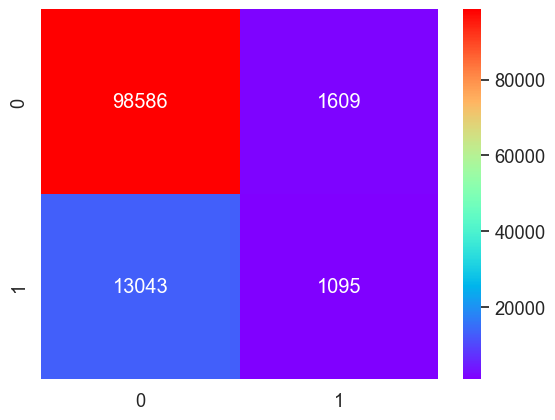

In [76]:
cm = confusion_matrix(y_test,clf.predict(X_test))#normalize = True
print('Matriz de Confusión')
sns.set(font_scale = 1.2)
sns.heatmap(cm, annot = True,fmt = 'd', cmap='rainbow')
plt.show()

In [77]:
print(classification_report(y_test,clf.predict(X_test) ))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93    100195
           1       0.40      0.08      0.13     14138

    accuracy                           0.87    114333
   macro avg       0.64      0.53      0.53    114333
weighted avg       0.82      0.87      0.83    114333



### 2.2 - Feature Selection

Vamos a comprobar si el modelo tras realizar la limpieza y transformación de los datos ha mejorado en algo. df_fe

In [78]:
df_fe.head()

Age  Region_Code Vehicle_Damage  Annual_Premium  Vintage  Response
0   44         28.0            Yes         40454.0      217         1
1   76          3.0             No         33536.0      183         0
2   47         28.0            Yes         38294.0       27         1
3   21         11.0             No         28619.0      203         0
4   29         41.0             No         27496.0       39         0

In [80]:
df_fe.shape

(380563, 6)

Por tanto, la unica variable categórica que es necesario transformar es Vehicle_Damage

In [81]:
# Transformar la variable 'Vehicle_Damage' de categórica a numérica (Yes = 1, No = 0)
df_fe['Vehicle_Damage'] = df_fe['Vehicle_Damage'].map({'Yes': 1, 'No': 0})

# Mostrar el DataFrame resultante
print(df_fe.head())

   Age  Region_Code  Vehicle_Damage  Annual_Premium  Vintage  Response
0   44         28.0               1         40454.0      217         1
1   76          3.0               0         33536.0      183         0
2   47         28.0               1         38294.0       27         1
3   21         11.0               0         28619.0      203         0
4   29         41.0               0         27496.0       39         0


In [82]:
X_fe = df_fe[list(df_fe.columns[:-1])] #todas las variables menos la variable respuesta
y_fe = df_fe['Response'] #variable respuesta

In [84]:
X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(X_fe, y_fe, test_size=0.3, random_state=42)

In [85]:
fig = ex.pie(y_train_fe,names='Response')
fig.update_layout(title='Proporción de observaciones de cada clase (0, 1)')
fig.show()

Vamos a ajustar el desbalanceo con SMOTE

In [87]:
# Inicializar el objeto SMOTE
smote = SMOTE(random_state=42)

# Aplicar SMOTE para equilibrar el dataset
X_train_res, y_train_res = smote.fit_resample(X_train_fe, y_train_fe)

# Verificar la distribución después de aplicar SMOTE
print("Distribución antes de SMOTE (y_train):")
print(y_train_fe.value_counts())

print("\nDistribución después de SMOTE (y_train_res):")
print(y_train_res.value_counts())

Distribución antes de SMOTE (y_train):
Response
0    233675
1     32719
Name: count, dtype: int64

Distribución después de SMOTE (y_train_res):
Response
0    233675
1    233675
Name: count, dtype: int64


Ahora el modelo de Random Forest

In [88]:
clf_fe = RandomForestClassifier(n_estimators= 100, class_weight=None, criterion='entropy', max_features='sqrt', min_samples_split=2, random_state=0)
clf_fe.fit(X_train_res, y_train_res)

RandomForestClassifier(criterion='entropy', random_state=0)

In [89]:
print('Comparación de Accuracy entre las muestras de entrenamiento y test:')
print(f'Accuracy (muestra de test): {"{:.2f}".format(accuracy_score(y_test_fe, clf_fe.predict(X_test_fe) ))}')
print(f'Accuracy (muestra de entrenamiento): {"{:.2f}".format(accuracy_score(y_train_res, clf_fe.predict(X_train_res) ))}')
print('Resto de métricas para la muestra de test:')
print("Precision:", "{:.2f}".format(precision_score(y_test_fe,clf_fe.predict(X_test_fe))))
print("Recall:", "{:.2f}".format(recall_score(y_test_fe, clf_fe.predict(X_test_fe))))
print("F1 score:","{:.2f}".format( f1_score(y_test_fe, clf_fe.predict(X_test_fe))))
y_probs = clf_fe.predict_proba(X_test_fe) # cálculo de probabilidades de cada clase para todos los registros
y_probs_1 = y_probs[:, 1] # probabilidades de la clase y = 1 para todos los registros que se requiere para la métrica AUC
print(f'AUC score: {"{:.2f}".format(roc_auc_score(y_test_fe, y_probs_1))}')

Comparación de Accuracy entre las muestras de entrenamiento y test:
Accuracy (muestra de test): 0.79
Accuracy (muestra de entrenamiento): 1.00
Resto de métricas para la muestra de test:
Precision: 0.29
Recall: 0.48
F1 score: 0.36
AUC score: 0.80


Matriz de Confusión


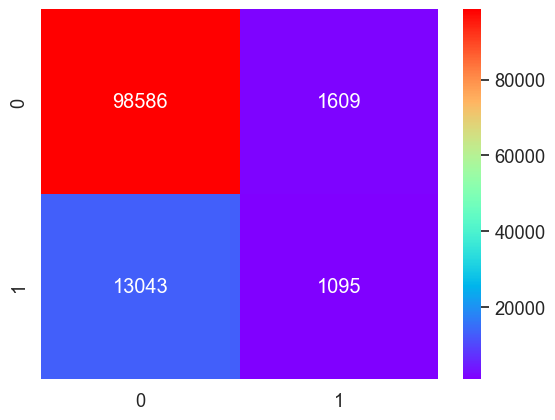

In [90]:
cm_fe = confusion_matrix(y_test_fe,clf_fe.predict(X_test_fe))#normalize = True
print('Matriz de Confusión')
sns.set(font_scale = 1.2)
sns.heatmap(cm, annot = True,fmt = 'd', cmap='rainbow')
plt.show()

In [91]:
print(classification_report(y_test_fe,clf_fe.predict(X_test_fe) ))

              precision    recall  f1-score   support

           0       0.92      0.84      0.88    100271
           1       0.29      0.48      0.36     13898

    accuracy                           0.79    114169
   macro avg       0.60      0.66      0.62    114169
weighted avg       0.84      0.79      0.81    114169



# Modelo con nuevas variables

In [94]:
df_fe_best = df_fe.copy()

In [95]:
df_fe_best["Age_Bin"] = pd.cut(df_fe_best["Age"], bins=[18, 25, 35, 50, 65, 100], labels=[1, 2, 3, 4, 5])
df_fe_best.head()

Age  Region_Code  Vehicle_Damage  Annual_Premium  Vintage  Response Age_Bin
0   44         28.0               1         40454.0      217         1       3
1   76          3.0               0         33536.0      183         0       5
2   47         28.0               1         38294.0       27         1       3
3   21         11.0               0         28619.0      203         0       1
4   29         41.0               0         27496.0       39         0       2

In [98]:
df_fe_best["Premium_per_Vintage"] = df_fe_best["Annual_Premium"] / df_fe_best["Vintage"]
df_fe_best.head()

Age  Region_Code  Vehicle_Damage  Annual_Premium  Vintage  Response  \
0   44         28.0               1         40454.0      217         1   
1   76          3.0               0         33536.0      183         0   
2   47         28.0               1         38294.0       27         1   
3   21         11.0               0         28619.0      203         0   
4   29         41.0               0         27496.0       39         0   

  Age_Bin  Premium_per_Vintage  
0       3           186.423963  
1       5           183.256831  
2       3          1418.296296  
3       1           140.980296  
4       2           705.025641

In [100]:
df_fe_best

Age  Region_Code  Vehicle_Damage  Annual_Premium  Vintage  Response  \
0        44         28.0               1         40454.0      217         1   
1        76          3.0               0         33536.0      183         0   
2        47         28.0               1         38294.0       27         1   
3        21         11.0               0         28619.0      203         0   
4        29         41.0               0         27496.0       39         0   
...     ...          ...             ...             ...      ...       ...   
381104   74         26.0               0         30170.0       88         0   
381105   30         37.0               0         40016.0      131         0   
381106   21         30.0               0         35118.0      161         0   
381107   68         14.0               1         44617.0       74         0   
381108   46         29.0               0         41777.0      237         0   

       Age_Bin  Premium_per_Vintage  
0            3           186.423963  
1            5           183.256831  
2            3          1418.296296  
3            1           140.980296  
4            2           705.025641  
...        ...                  ...  
381104       5           342.840909  
381105       2           305.465649  
381106       1           218.124224  
381107       5           602.932432  
381108       3           176.274262  

[380563 rows x 8 columns]

In [101]:
# Mover la columna 'Response' al final
df_fe_best = df_fe_best[[col for col in df_fe_best.columns if col != 'Response'] + ['Response']]

df_fe_best.head()

Age  Region_Code  Vehicle_Damage  Annual_Premium  Vintage Age_Bin  \
0   44         28.0               1         40454.0      217       3   
1   76          3.0               0         33536.0      183       5   
2   47         28.0               1         38294.0       27       3   
3   21         11.0               0         28619.0      203       1   
4   29         41.0               0         27496.0       39       2   

   Premium_per_Vintage  Response  
0           186.423963         1  
1           183.256831         0  
2          1418.296296         1  
3           140.980296         0  
4           705.025641         0

In [102]:
X_fe_best = df_fe_best[list(df_fe_best.columns[:-1])] #todas las variables menos la variable respuesta
y_fe_best = df_fe_best['Response'] #variable respuesta

In [103]:
X_train_fe_best, X_test_fe_best, y_train_fe_best, y_test_fe_best = train_test_split(X_fe_best, y_fe_best, test_size=0.3, random_state=42)

In [104]:
# Inicializar el objeto SMOTE
smote = SMOTE(random_state=42)

# Aplicar SMOTE para equilibrar el dataset
X_train_res_best, y_train_res_best = smote.fit_resample(X_train_fe_best, y_train_fe_best)

# Verificar la distribución después de aplicar SMOTE
print("Distribución antes de SMOTE (y_train):")
print(y_train_fe_best.value_counts())

print("\nDistribución después de SMOTE (y_train_res):")
print(y_train_res_best.value_counts())

Distribución antes de SMOTE (y_train):
Response
0    233675
1     32719
Name: count, dtype: int64

Distribución después de SMOTE (y_train_res):
Response
0    233675
1    233675
Name: count, dtype: int64


In [106]:
clf_fe_best = RandomForestClassifier(n_estimators= 100, class_weight=None, criterion='entropy', max_features='sqrt', min_samples_split=2, random_state=0)
clf_fe_best.fit(X_train_res_best, y_train_res_best)

RandomForestClassifier(criterion='entropy', random_state=0)

In [107]:
print('Comparación de Accuracy entre las muestras de entrenamiento y test:')
print(f'Accuracy (muestra de test): {"{:.2f}".format(accuracy_score(y_test_fe_best, clf_fe_best.predict(X_test_fe_best) ))}')
print(f'Accuracy (muestra de entrenamiento): {"{:.2f}".format(accuracy_score(y_train_res_best, clf_fe_best.predict(X_train_res_best) ))}')
print('Resto de métricas para la muestra de test:')
print("Precision:", "{:.2f}".format(precision_score(y_test_fe_best,clf_fe_best.predict(X_test_fe_best))))
print("Recall:", "{:.2f}".format(recall_score(y_test_fe_best, clf_fe_best.predict(X_test_fe_best))))
print("F1 score:","{:.2f}".format( f1_score(y_test_fe_best, clf_fe_best.predict(X_test_fe_best))))
y_probs_fe_best = clf_fe_best.predict_proba(X_test_fe_best) # cálculo de probabilidades de cada clase para todos los registros
y_probs_1_fe_best = y_probs_fe_best[:, 1] # probabilidades de la clase y = 1 para todos los registros que se requiere para la métrica AUC
print(f'AUC score: {"{:.2f}".format(roc_auc_score(y_test_fe_best, y_probs_1_fe_best))}')

Comparación de Accuracy entre las muestras de entrenamiento y test:
Accuracy (muestra de test): 0.82
Accuracy (muestra de entrenamiento): 1.00
Resto de métricas para la muestra de test:
Precision: 0.30
Recall: 0.33
F1 score: 0.31
AUC score: 0.80


Matriz de Confusión


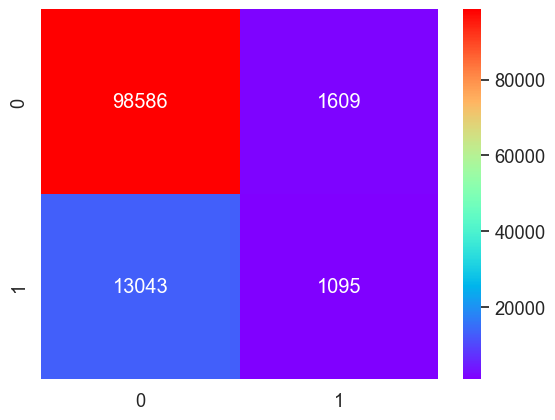

In [108]:
cm_fe_best = confusion_matrix(y_test_fe_best,clf_fe_best.predict(X_test_fe_best))#normalize = True
print('Matriz de Confusión')
sns.set(font_scale = 1.2)
sns.heatmap(cm, annot = True,fmt = 'd', cmap='rainbow')
plt.show()

In [109]:
print(classification_report(y_test_fe_best,clf_fe_best.predict(X_test_fe_best)))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90    100271
           1       0.30      0.33      0.31     13898

    accuracy                           0.82    114169
   macro avg       0.60      0.61      0.61    114169
weighted avg       0.83      0.82      0.83    114169



# CONCLUSIONES

In [92]:
def obtener_metricas(clf, X_train, y_train, X_test, y_test, nombre_modelo):
    metrics = {}
    metrics["Modelo"] = nombre_modelo
    metrics["Accuracy (Train)"] = accuracy_score(y_train, clf.predict(X_train))
    metrics["Accuracy (Test)"] = accuracy_score(y_test, clf.predict(X_test))
    metrics["Precision"] = precision_score(y_test, clf.predict(X_test))
    metrics["Recall"] = recall_score(y_test, clf.predict(X_test))
    metrics["F1 Score"] = f1_score(y_test, clf.predict(X_test))
    y_probs = clf.predict_proba(X_test)[:, 1]
    metrics["AUC Score"] = roc_auc_score(y_test, y_probs)
    return metrics

# Obtener métricas de ambos modelos
metrics_1 = obtener_metricas(clf, X_train, y_train, X_test, y_test, "Modelo Base")
metrics_2 = obtener_metricas(clf_fe, X_train_res, y_train_res, X_test_fe, y_test_fe, "Modelo FE")

# Crear un DataFrame para compararlos
df_comparacion = pd.DataFrame([metrics_1, metrics_2])

# Mostrar la tabla
print(df_comparacion)

        Modelo  Accuracy (Train)  Accuracy (Test)  Precision    Recall  \
0  Modelo Base          0.999985         0.871848   0.404956  0.077451   
1    Modelo FE          0.997666         0.793184   0.289010  0.478702   

   F1 Score  AUC Score  
0  0.130032   0.842707  
1  0.360420   0.801608  
